## Notebook made by  

|** Name** | **Student id** | **email**|
|: |:-|:-| 
|Brandon Cchung|10800840|bctcchung@gmail.com|
|Sidney de Vries  |10724087 |sidney.de.vries96@gmail.com|

### Pledge (taken from [Coursera's Honor Code](https://www.coursera.org/about/terms/honorcode) )



Put here a selfie with your photo where you hold a signed paper with the following text: (if this is team work, put two selfies here). The link must be to some place on the web, not to a local file. 

> My answers to homework, quizzes and exams will be my own work (except for assignments that explicitly permit collaboration).

>I will not make solutions to homework, quizzes or exams available to anyone else. This includes both solutions written by me, as well as any official solutions provided by the course staff.

>I will not engage in any other activities that will dishonestly improve my results or dishonestly improve/hurt the results of others.

<img src='https://cloud.githubusercontent.com/assets/10861155/7042930/cf749982-dde5-11e4-9e8c-4c41080faf55.jpg'/><img src='https://github.com/sidneyd3vries/datascience/blob/master/foto.jpg?raw=true'/>

In [1]:
import pandas as pd
from pandas import DataFrame
import re
from lxml import etree 
from bz2file import BZ2File
import codecs
from nltk import pos_tag
from collections import defaultdict, Counter
import itertools
from  itertools import combinations
from __future__ import division
from math import sqrt 
import csv
from os import listdir
from lxml import objectify
from itertools import chain
import numpy as np
from IPython.display import HTML

In [2]:
def stringify_children(node):
    """source: http://stackoverflow.com/questions/4624062/get-all-text-inside-a-tag-in-lxml"""
    from lxml.etree import tostring
    from itertools import chain
    parts = ([node.text] +
            list(chain(*([c.text, tostring(c), c.tail] for c in node.getchildren()))) +
            [node.tail])
    # filter removes possible Nones in texts and tails
    return ''.join(filter(None, parts)).encode('utf-8')

def clean_string(string):
    """ Removes tags, newline characters and lowercases everything"""
    string = re.sub('<[^<]+?>', '', string)
    string = string.replace('\n', '')
    return string.lower().strip()

badfilecount = 0
c = 0

files = [f for f in listdir('Wilders2014')]
tuplelist = []
for xmlfile in files:
    date = xmlfile[5:-4]
    if date != '':
        with open("Wilders2014/"+ xmlfile) as f:

            parsed = etree.parse(f)

            achternaam = parsed.xpath("./handelingen/agendapunt/spreekbeurt/spreker/naam/achternaam")
            achternaamlist = [i.text for i in achternaam]


            rol = parsed.xpath("./handelingen/agendapunt/spreekbeurt/spreker/voorvoegsels")
            rollist = [i.text for i in rol]

            text = parsed.xpath("./handelingen/agendapunt/spreekbeurt/tekst")
            textlist = [clean_string(stringify_children(i)) for i in text]

            if not len(rollist) == len(achternaamlist) == len(textlist):
                badfilecount  += 1
            else:
                for tup in zip(rollist, achternaamlist, textlist):
                    tuplelist.append(tup)
                
            
            # Debug printing
            c += 1
            if c%500 == 0:
                print '%s files processed' %c

print "%s files of %s were not processed because of an error in xml structure." %(badfilecount, len(files))

500 files processed
1000 files processed
1500 files processed
2000 files processed
2500 files processed
3000 files processed
3500 files processed
4000 files processed
4500 files processed
5000 files processed
5500 files processed
6000 files processed
170 files of 6443 were not processed because of an error in xml structure.


In [3]:
# Transform list to dict where the key is the speaker, the value a list of all the words said by that person

data = {}

for tup in tuplelist:
    person = ' '.join((tup[0],tup[1]))
    # Filter text more
    text = tup[2]
    if person in data:
        data[person] += ' ' + text
    else:
        data[person] = text

In [63]:
import nltk
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

def fixed(textlist):
    
    text = ''.join(textlist)
    # Remove nonsensical digits
    text = ''.join([i for i in text if not i.isdigit()])
    
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # Remove stopwords
    stopwords = nltk.corpus.stopwords.words('dutch')
    textnotStop = [w for w in tokens if w not in stopwords and len(w) > 1]
    
    # Most common words
    textCountStop = Counter(textnotStop)
    mostCommon = textCountStop.most_common(50)
    mostCommon = dict(mostCommon)
    
    text = ' '.join(mostCommon)

    return text

In [64]:
import re, math
from collections import Counter

''' source: http://stackoverflow.com/questions/15173225/how-to-calculate-cosine-similarity-given-2-sentence-strings-python '''

WORD = re.compile(r'\w+')

def get_cosine(vec1, vec2):
     intersection = set(vec1.keys()) & set(vec2.keys())
     numerator = sum([vec1[x] * vec2[x] for x in intersection])

     sum1 = sum([vec1[x]**2 for x in vec1.keys()])
     sum2 = sum([vec2[x]**2 for x in vec2.keys()])
     denominator = math.sqrt(sum1) * math.sqrt(sum2)

     if not denominator:
        return 0.0
     else:
        return float(numerator) / denominator

def text_to_vector(text):
     words = WORD.findall(text)
     return Counter(words)

In [66]:
# Remove (lesser-known) politicians who speak about less than 200 words a day
tokenizer = RegexpTokenizer(r'\w+')
listofpoliticians = [key for key, val in data.iteritems() if len(tokenizer.tokenize(val)) > 70000]

output = []
politicianlist = []
otherlist = []
cosinelist = []

for i in listofpoliticians:
    politician = fixed(data[i])
    for d in listofpoliticians:
        other = fixed(data[d])
    
        vector1 = text_to_vector(politician)
        vector2 = text_to_vector(other)

        cosine = get_cosine(vector1, vector2)
            
        politicianlist.append(i)
        otherlist.append(d)
        cosinelist.append(cosine)

fused = zip(politicianlist, otherlist, cosinelist)
for entry in fused:
    output.append(entry)

C:\Users\bcc\Anaconda\lib\site-packages\IPython\kernel\__main__.py:16: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [67]:
df = pd.DataFrame(output)
df = df.pivot(index=0, columns=1, values=2)

df.to_csv('similarity.csv', encoding= 'utf-8')

In [73]:
df = pd.DataFrame.from_csv('similarity.csv')
df['De heer Wilders'].nlargest(10)

0
De heer Wilders             1.00
De heer Madlener            0.66
De heer Pechtold            0.66
De heer Roemer              0.66
De heer Van Haersma Buma    0.62
Mevrouw Thieme              0.58
De heer Harbers             0.56
De heer Tony van Dijck      0.56
De heer Van Ojik            0.56
De heer Van Raak            0.56
Name: De heer Wilders, dtype: float64

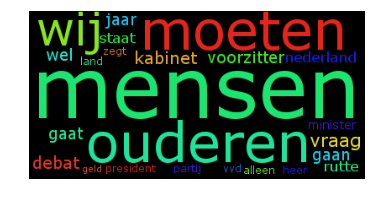

In [356]:
% matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
 
wordcloud = WordCloud(font_path='verdana.ttf').generate(text1)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Similarity of Dutch Politicians by Word Usage

### Brandon Cchung (10800840) & Sidney de Vries (10724087)


### Abstract

hoogout 150 woorden